In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import contextily as cx
import hamhelper.colours as hc
import hamhelper.plotting as hp
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from math import trunc
import matplotlib.image as mpimg

# Define helper functions
def get_lat_lon(df, col='geo_point_2d'):
    loc = df[col].to_numpy()
    latitudes = np.empty_like(loc)
    longitudes = np.empty_like(loc)
    for _, entry in enumerate(loc[::]):
        lat, lon = entry.split(', ')
        latitudes[_] = float(lat)
        longitudes[_] = float(lon)
    return latitudes, longitudes

# define custom colormap for values that shouldnt be less than zero
hmap = hc.HamColour.from_hex('dirt', ['#9e6d30', '#7c4807'])
# hmap += hc.HamColour.from_name('hot', length=256)

# Making the Plot


### Load the Data Functions

In [2]:


def load_data_files_as_df(indicator_file=r"data\indicator-data.geojson", garden_file=r'data\community-gardens-and-food-trees.csv'):
    """Load the given indicator and garden data from file to be used in analysis"""
    # Load in data: INDICATORS
    df_geo = gpd.read_file(indicator_file)
    garden_file = garden_file
    df_garden = pd.read_csv(garden_file, delimiter=';').iloc[1: , :]  # drop first row of all NaNs for pre 2010 private entries
    return df_geo, df_garden


def select_data(indicator_year, indicator_geolevel, indicator_quality, df_geo, df_garden):
    """Select and filter appropriate data from the loaded data frames, returns what is needed to plot the data."""  
    # %---------- Indicator Data ----------%
    selection_type = [indicator_quality]
    selection_year = [indicator_year]
    selection_survey = [indicator_geolevel]

    selected_data = df_geo[df_geo['indicatorname'].isin(selection_type)]
    selected_data = selected_data[selected_data['periodlabel'].isin(selection_year)]
    selected_data = selected_data[selected_data['geolevelname'].isin(selection_survey)]

    geom = selected_data.loc[:, 'geometry'].to_numpy()
    val = selected_data.loc[:, 'actualvalue'].to_numpy()
    geoName = selected_data.loc[:, 'geographyname'].to_numpy()

    geoGeom = gpd.GeoSeries(geom) 

    # %---------- Garden Data ----------%
    lat, lon = get_lat_lon(df_garden,)

    trees= df_garden['NUMBER_OF_FOOD_TREES'].to_numpy()
    trees = np.where(trees == 'yes', 1, trees).astype(float)
    trees = np.where(np.isnan(trees), -40, trees)

    plots = df_garden['NUMBER_OF_PLOTS'].to_numpy()
    plots = np.where(np.isnan(plots), -40, plots)

    year_created = df_garden['YEAR_CREATED'].to_numpy()
    year_created = np.where(year_created == 'pre-1970', 1900, year_created)
    year_created = np.where(year_created == 'pre 2000', 1900, year_created)
    year_created = np.where(year_created == 'NaN', 1900, year_created).astype(float)
    year_created = np.where(np.isnan(year_created), 1900, year_created)

    return geoGeom, geom, val, geoName, lat, lon, trees, plots, year_created

### Load in Data
df_geo, df_garden = load_data_files_as_df()


In [16]:
def generate_plot(geoGeom, geom, val, geoName, lat, lon, trees, plots, year_created, choropleth_indicator, year, area_indicator, scaleBounds=False,
                  colormap='ptol_nightfall', fileName='plots/test', map_edge_padding=0.005, map_style='terrain', plot_size=np.array([5.5, 4.4])*2):
    
    fig, ax = plt.subplots(1, 1, figsize = plot_size)
    colors = hc.HamColour.from_name(colormap)

    # Download the map
    extent = geoGeom.geometry.total_bounds
    west, south, east, north = extent
    van_img, van_ext = cx.bounds2img(west, south, east, north, ll=True, source=
                                    fr'https://tiles.stadiamaps.com/tiles/stamen_{map_style}'+r'_background/{z}/{x}/{y}{r}.png?api_key=0c79f47c-8641-4ae2-9856-ffbb3c3b6ac4')
    van_img_roads, van_ext_txt_roads = cx.bounds2img(west, south, east, north, ll=True, source=
                                                    fr' https://tiles.stadiamaps.com/tiles/stamen_{map_style}'+r'_lines/{z}/{x}/{y}{r}.png?api_key=0c79f47c-8641-4ae2-9856-ffbb3c3b6ac4')
    # van_img_txt, van_ext_txt = cx.bounds2img(west, south, east, north, ll=True, source=
    #                                          fr'https://tiles.stadiamaps.com/tiles/stamen_{map_style}'+r'_labels/{z}/{x}/{y}{r}.png?api_key=0c79f47c-8641-4ae2-9856-ffbb3c3b6ac4')
    

    print(van_ext_txt_roads)
    if area_indicator == 'Local Area':
        west += -0.0845
        east += 0.064
        north += 0.0301
        south += -0.0472
    else:
        west += -0.0445
        east += 0.064
        north += 0.0301
        south += -0.0472

    # Plot the map
    bbox = np.array([west, east, south, north])  # + np.array([-0.03, 0, 0, -0.005])
    # ax.imshow(van_img, zorder=1, extent=bbox, alpha=0.7)
    ax.imshow(van_img_roads, zorder=10, extent=bbox)

    # Make the colormap
    totSize = val.size
    hasGeom = np.zeros(val.shape)
    for i, (g, v) in enumerate(zip(geom[::],val[::])):
        if type(g) != type(None):
            hasGeom[i] = 1
            print(f'{geoName[i]:<38} -> {str(type(g)):<53} = {v}%')
            gpd.GeoSeries(g).plot(ax = ax, color = colors(v/100), zorder = 2, alpha = 0.9)

    # make the colour bar
    val_limits = np.array([trunc(np.min(val)/10)*10, round(np.max(val),-1)])
    print(val)
    print(val_limits)
    if scaleBounds:
        cmappable = ScalarMappable(norm=Normalize(*val_limits), cmap=colors.cmap)
    else:
        cmappable = ScalarMappable(norm=Normalize(*val_limits), cmap=colors.truncate(val_limits[0]/100, val_limits[1]/100, update=False).cmap)
        pass
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="3%", pad=0.05)
    cb = plt.colorbar(cmappable, cax=cax, label = f'{choropleth_indicator}', orientation = 'horizontal', aspect=10)
    cb.outline.set_visible(False)

    # Add garden scatter
    c = ax.scatter(lon[::], lat[::], s=plots + 1, c=np.where(year_created >= int(year), 0, 1), zorder = 100, cmap = hmap.cmap,
                   label = 'Size of garden')

    print(f'{np.sum(hasGeom):} out of {totSize} have a shape object!')
    

    # Scale the border and axes
    west, south, east, north = extent
    borderPad = map_edge_padding
    ax.set(xlim = [west-borderPad, east+borderPad*0], ylim = [south-borderPad, north+borderPad])
    hp.despine(left=False, bottom=False, axis=ax)
    ax.set(xticks=[], yticks=[])
    ax.set_aspect(0.1)
    cax.set_aspect(1.6)
    cax.set_xticks(np.arange(val_limits[0], val_limits[1]+1, 10), labels=[f'{_}%' for _ in np.arange(val_limits[0], val_limits[1]+1, 10)])
    ax.set_title(f'{year} Public Food Gardens Towards Quality of Everyday Life', loc='left', fontsize = 12)
    
    ax.scatter([], [], s=np.mean(plots), c='#9e6d30',label='Before 2014')
    ax.scatter([], [], s=np.mean(plots), c='#7c4807',label='After 2014')
    legend = ax.legend(loc='upper left', framealpha=0, fontsize=10, title='Community Gardens & Food Tree Projects')
    legend._legend_box.align = "left"
    
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    # Block out richmond and north vancouver
    vancouverMaskImg = mpimg.imread(r'plots\vancouverEdgeMask_white.png')
    vancouevrImg = ax.imshow(vancouverMaskImg, zorder=10, extent= [*xlims, *ylims], interpolation='none')

    # Save map
    if False:
        plt.savefig(f'{fileName}.png', dpi=300, bbox_inches = 'tight')
        plt.savefig(f'{fileName}.pdf', dpi=300, bbox_inches = 'tight')
    return fig, ax

Loaded!
(-13726867.28756509, -13687731.529083082, 6300857.115603647, 6330208.934465155)
Killarney                              -> <class 'shapely.geometry.multipolygon.MultiPolygon'>  = 35.0%
UBC                                    -> <class 'shapely.geometry.polygon.Polygon'>            = 39.0%
Shaughnessy/Arbutus-Ridge/Kerrisdale   -> <class 'shapely.geometry.multipolygon.MultiPolygon'>  = 47.0%
Kitsilano                              -> <class 'shapely.geometry.polygon.Polygon'>            = 58.0%
Renfrew-Collingwood                    -> <class 'shapely.geometry.polygon.Polygon'>            = 36.0%
Grandview-Woodland                     -> <class 'shapely.geometry.polygon.Polygon'>            = 45.0%
Mount Pleasant                         -> <class 'shapely.geometry.polygon.Polygon'>            = 52.0%
Sunset                                 -> <class 'shapely.geometry.polygon.Polygon'>            = 41.0%
South Cambie/Oakridge                  -> <class 'shapely.geometry.polygon.Polyg

c:\Users\hamis\OneDrive - Simon Fraser University (1sfu)\SFU Coding\CMNS 313\.venv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\hamis\OneDrive - Simon Fraser University (1sfu)\SFU Coding\CMNS 313\.venv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\hamis\OneDrive - Simon Fraser University (1sfu)\SFU Coding\CMNS 313\.venv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


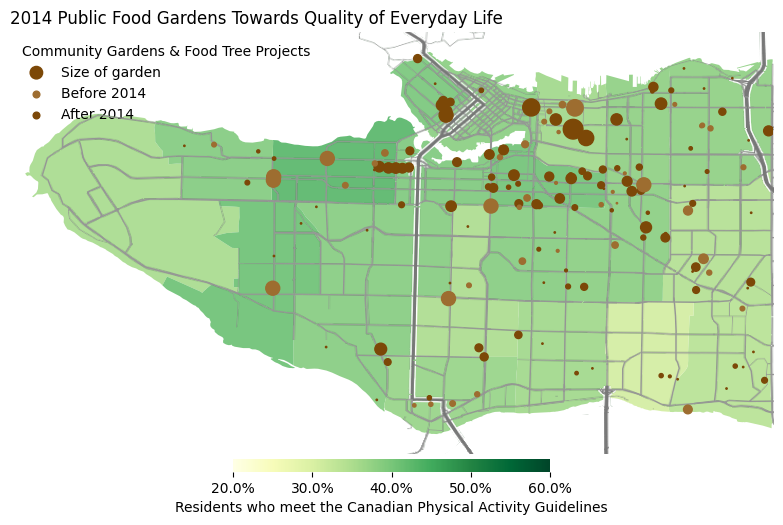

Plotted!


In [17]:
# %----------------- User -----------------% 

# Indicator Settings
choropleth_indicator = 'Residents who meet the Canadian Physical Activity Guidelines'
year = '2014'
area_indicator = 'Local Area MHMC'

# Garden & food Trees Settings

# Plot Settings
colormap = 'ptol_nightfall'
map_edge_padding = 0.005
map_style = 'terrain'  # 'toner' or 'terrain'
plot_size = np.array([3.2, 3.3])*4

# File saving
fileName = 'plots/' + 'garden-indicator-projectDate'

# %-------------- Filter Data --------------%
geoGeom, geom, val, geoName, lat, lon, trees, plots, year_created = select_data(year, area_indicator, choropleth_indicator,
                                                                                df_geo, df_garden)

print('Loaded!')

fig, ax = generate_plot(geoGeom, geom, val, geoName, lat, lon, trees, plots, year_created, colormap='YlGn', scaleBounds=True,
                        choropleth_indicator=choropleth_indicator, year=year, area_indicator=area_indicator, plot_size=plot_size)

ax.set_aspect(1.3)
plt.savefig(f'{fileName}.png', dpi=300, bbox_inches = 'tight')
plt.savefig(f'{fileName}.webp', dpi=300, bbox_inches = 'tight')
plt.savefig(f'{fileName}.pdf', dpi=300, bbox_inches = 'tight')
plt.show()

print('Plotted!')

### Making several plots to compare indicators

Killarney                              -> <class 'shapely.geometry.multipolygon.MultiPolygon'>  = 35.0%
UBC                                    -> <class 'shapely.geometry.polygon.Polygon'>            = 39.0%
Shaughnessy/Arbutus-Ridge/Kerrisdale   -> <class 'shapely.geometry.multipolygon.MultiPolygon'>  = 47.0%
Kitsilano                              -> <class 'shapely.geometry.polygon.Polygon'>            = 58.0%
Renfrew-Collingwood                    -> <class 'shapely.geometry.polygon.Polygon'>            = 36.0%
Grandview-Woodland                     -> <class 'shapely.geometry.polygon.Polygon'>            = 45.0%
Mount Pleasant                         -> <class 'shapely.geometry.polygon.Polygon'>            = 52.0%
Sunset                                 -> <class 'shapely.geometry.polygon.Polygon'>            = 41.0%
South Cambie/Oakridge                  -> <class 'shapely.geometry.polygon.Polygon'>            = 38.0%
Hastings-Sunrise                       -> <class 'shapely.geomet

c:\Users\hamis\OneDrive - Simon Fraser University (1sfu)\SFU Coding\CMNS 313\.venv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\hamis\OneDrive - Simon Fraser University (1sfu)\SFU Coding\CMNS 313\.venv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


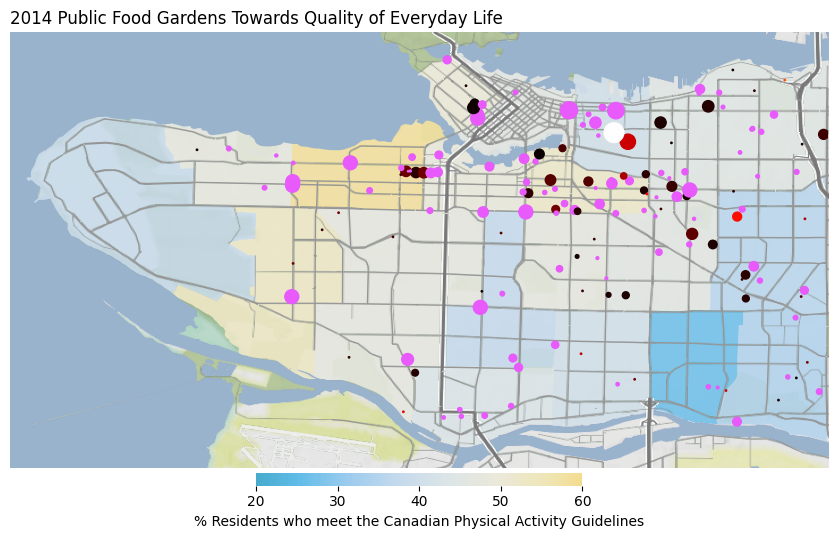

done ResidentsWhoMeetTheCanadianPhysicalActivityGuidelines_LocalAreaMhmc
West Point Grey                        -> <class 'shapely.geometry.polygon.Polygon'>            = 74.0%
Fairview                               -> <class 'shapely.geometry.polygon.Polygon'>            = 76.0%
Shaughnessy-Arbutus-Ridge              -> <class 'shapely.geometry.polygon.Polygon'>            = 76.0%
Oakridge                               -> <class 'shapely.geometry.polygon.Polygon'>            = 63.0%
Hastings-Sunrise                       -> <class 'shapely.geometry.polygon.Polygon'>            = 62.0%
Killarney                              -> <class 'shapely.geometry.multipolygon.MultiPolygon'>  = 66.0%
Kensington-Cedar Cottage               -> <class 'shapely.geometry.polygon.Polygon'>            = 66.0%
Downtown                               -> <class 'shapely.geometry.polygon.Polygon'>            = 66.0%
Victoria-Fraserview                    -> <class 'shapely.geometry.multipolygon.MultiPolygon'> 

c:\Users\hamis\OneDrive - Simon Fraser University (1sfu)\SFU Coding\CMNS 313\.venv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\hamis\OneDrive - Simon Fraser University (1sfu)\SFU Coding\CMNS 313\.venv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


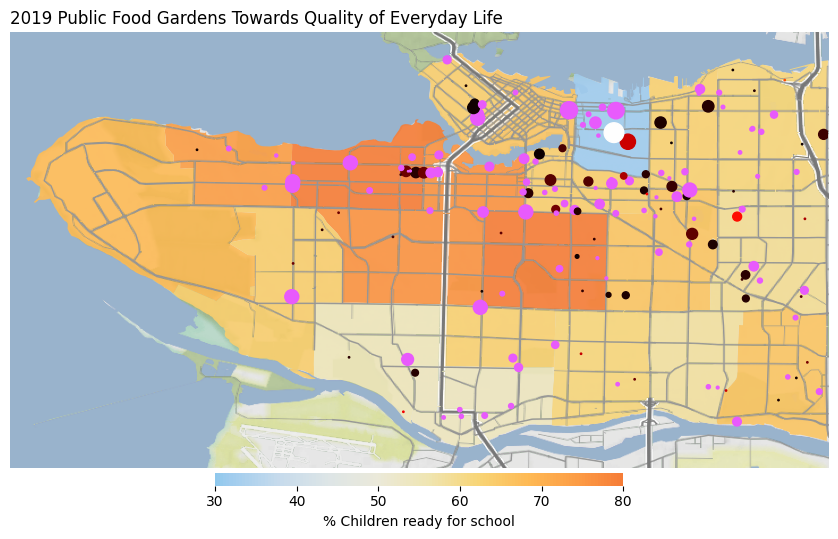

done ChildrenReadyForSchool_LocalAreaEdi
West Point Grey                        -> <class 'shapely.geometry.polygon.Polygon'>            = 20.0%
Victoria-Fraserview                    -> <class 'shapely.geometry.multipolygon.MultiPolygon'>  = 21.0%
Shaughnessy                            -> <class 'shapely.geometry.polygon.Polygon'>            = 16.0%
Hastings-Sunrise                       -> <class 'shapely.geometry.polygon.Polygon'>            = 19.0%
Kensington-Cedar Cottage               -> <class 'shapely.geometry.polygon.Polygon'>            = 19.0%
Riley Park                             -> <class 'shapely.geometry.polygon.Polygon'>            = 9.0%
Sunset                                 -> <class 'shapely.geometry.polygon.Polygon'>            = 21.0%
Kitsilano                              -> <class 'shapely.geometry.polygon.Polygon'>            = 12.0%
South Cambie                           -> <class 'shapely.geometry.polygon.Polygon'>            = 11.0%
Arbutus-Ridge           

c:\Users\hamis\OneDrive - Simon Fraser University (1sfu)\SFU Coding\CMNS 313\.venv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\hamis\OneDrive - Simon Fraser University (1sfu)\SFU Coding\CMNS 313\.venv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


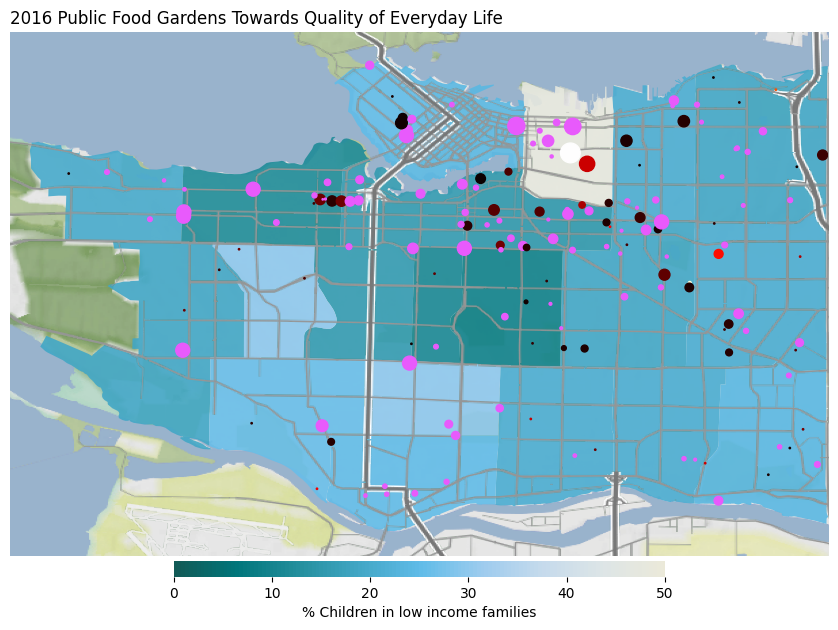

done ChildrenInLowIncomeFamilies_LocalArea
Marpole                                -> <class 'shapely.geometry.polygon.Polygon'>            = 25.0%
Grandview-Woodland                     -> <class 'shapely.geometry.polygon.Polygon'>            = 23.0%
Mount Pleasant                         -> <class 'shapely.geometry.polygon.Polygon'>            = 18.0%
Sunset                                 -> <class 'shapely.geometry.polygon.Polygon'>            = 18.0%
Oakridge                               -> <class 'shapely.geometry.polygon.Polygon'>            = 26.0%
Victoria-Fraserview                    -> <class 'shapely.geometry.multipolygon.MultiPolygon'>  = 17.0%
Renfrew-Collingwood                    -> <class 'shapely.geometry.polygon.Polygon'>            = 19.0%
West Point Grey                        -> <class 'shapely.geometry.polygon.Polygon'>            = 22.0%
Kensington-Cedar Cottage               -> <class 'shapely.geometry.polygon.Polygon'>            = 17.0%
Killarney            

c:\Users\hamis\OneDrive - Simon Fraser University (1sfu)\SFU Coding\CMNS 313\.venv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\hamis\OneDrive - Simon Fraser University (1sfu)\SFU Coding\CMNS 313\.venv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


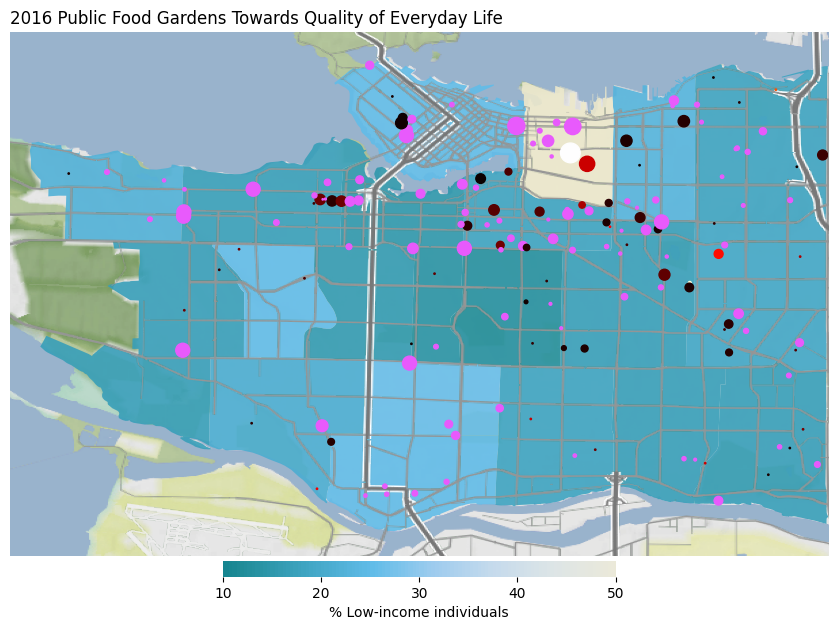

done Low-IncomeIndividuals_LocalArea
Kensington-Cedar Cottage               -> <class 'shapely.geometry.polygon.Polygon'>            = 31.0%
Fairview                               -> <class 'shapely.geometry.polygon.Polygon'>            = 33.0%
South Cambie                           -> <class 'shapely.geometry.polygon.Polygon'>            = 33.0%
Downtown                               -> <class 'shapely.geometry.polygon.Polygon'>            = 44.0%
Shaughnessy                            -> <class 'shapely.geometry.polygon.Polygon'>            = 33.0%
Renfrew-Collingwood                    -> <class 'shapely.geometry.polygon.Polygon'>            = 33.0%
Dunbar-Southlands                      -> <class 'shapely.geometry.multipolygon.MultiPolygon'>  = 33.0%
Marpole                                -> <class 'shapely.geometry.polygon.Polygon'>            = 40.0%
Riley Park                             -> <class 'shapely.geometry.polygon.Polygon'>            = 29.0%
Strathcona                 

c:\Users\hamis\OneDrive - Simon Fraser University (1sfu)\SFU Coding\CMNS 313\.venv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\hamis\OneDrive - Simon Fraser University (1sfu)\SFU Coding\CMNS 313\.venv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


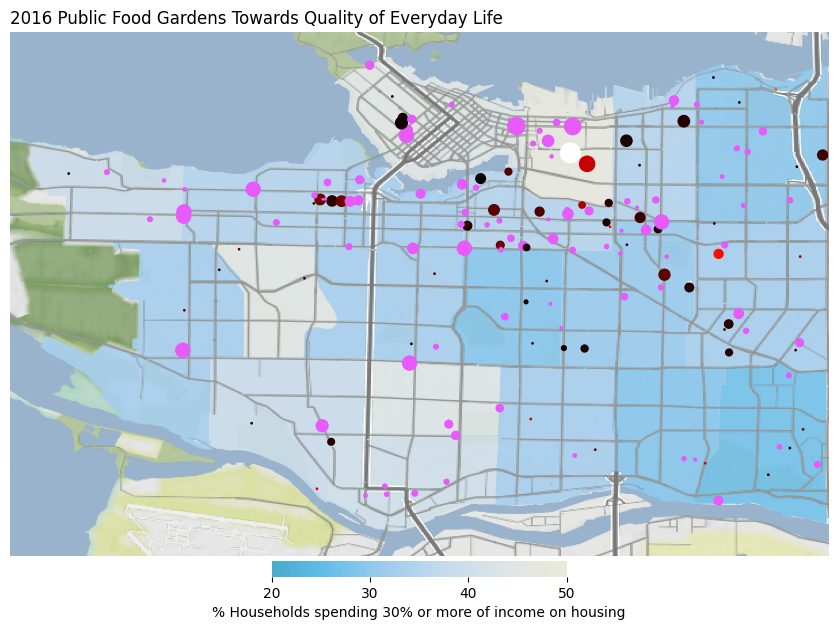

done HouseholdsSpending30%OrMoreOfIncomeOnHousing_LocalArea


In [29]:
# Make a few different plots!
data_selections = [['Residents who meet the Canadian Physical Activity Guidelines', '2014', 'Local Area MHMC'],
                   ['Children ready for school', '2019', 'Local Area EDI'],
                   ['Children in low income families', '2016', 'Local Area'],
                   ['Low-income individuals', '2016', 'Local Area'],
                   [r'Households spending 30% or more of income on housing', '2016', 'Local Area'],
                   ]

colormap = 'ptol_nightfall'
map_type = 'terrain'

for choropleth_indicator1, year1, area_indicator1 in data_selections:
    
    geoGeom, geom, val, geoName, lat, lon, trees, plots = select_data(year1, area_indicator1, choropleth_indicator1, df_geo, df_garden)

    indicator_type = choropleth_indicator1.title().replace(" ", "")
    survey_type = area_indicator1.title().replace(" ", "")
    identifier = '_'.join([indicator_type,survey_type])

    fig, ax = generate_plot(geoGeom, geom, val, geoName, lat, lon, trees, plots,
                            fileName = fileName + '_' + identifier + '_' + map_type , colormap=colormap, map_style=map_type,
                            choropleth_indicator=choropleth_indicator1, year=year1, area_indicator=area_indicator1)
    plt.show()
    print(f'done {identifier}')